# Community detection using bounded confidence à la Hansen and Ghrist

In [1]:
#%pylab qt5
#%precision 5
#set_printoptions(precision=5)
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (11, 7)
import networkx as nx
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import csv
from statistics import stdev,mean

## The karate club graph G

For now we will investigate the karate club graph to test the community detection

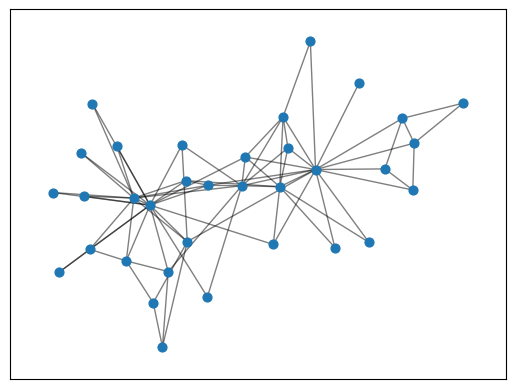

In [2]:
# load the karate club graph
G = nx.karate_club_graph()
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

### Defining some functions

To specify which distance function to use, change the phi in abl\
In basic case, phi2 takes 1.5 times as long as phi1, phi3 even twice as long

In [2]:
def phi(dist):
    """
    threshold function
    """
    if dist<1:
        res=1-dist
    else:
        res=0
    return res

In [26]:
def phi2(dist):
    """
    An alternative bump function: sharp boarder of ignoring
    """
    if dist<1:
        re=1-dist**2
    else:
        re=0
    return re

In [27]:
def phi3(dist):
    """
    The third bump function: quadratic decay of influence
    """
    if dist<1:
        re=(1-dist)**2
    else:
        re=0
    return re 

In [14]:
def phi4(dist):
    """
    The fourth bump function: some wave that is steep for small and for big x
    """
    if dist<1:
        re=1-dist-np.sin(2*np.pi * dist)/7
    else:
        re=0
    return re 

In [51]:
def abl(t,arr):
    """
    The derivative function for solving the dynamics
    """
    inc=nx.incidence_matrix(G,oriented=True).toarray()
    v=[]
    for k in nx.edges(G):
        v=np.append(v,[phi(abs(arr[k[0]]-arr[k[1]]))])
    return -np.dot(np.matmul(np.matmul(inc,np.diag(v)),np.transpose(inc)),arr)

In [4]:
def test(lsg):
    """
    tests if a solution needs to be further calculated (1) or already converged sufficiently (0)
    """
    t=0
    for e in nx.edges(G):
        if abs(lsg[e[0]]-lsg[e[1]])>0.0049 and abs(lsg[e[0]]-lsg[e[1]])<1:
            t=1
    return t        

In [5]:
def sol(G,r):
    """
    solves the dynamics for a given graph and a random starting distribution on -r/2,r/2
    """
    b=0
    restarts=0
    while b==0:
        y=[] #start value
        for i in range(G.number_of_nodes()):
            y=np.append(y,r*np.random.random()-r/2) #ok, range 2 scheint zu niedrig zu sein, range 3 ist schon besser...
        sol=scipy.integrate.solve_ivp(abl,[0,1],y,t_eval=[1])
        s=0
        while test(sol.y[:,0])==1 and s<1000:
            sol=scipy.integrate.solve_ivp(abl,[0,1],sol.y[:,0],t_eval=[1])
            s=s+1
        if s==1000:
            restarts=restarts+1
        if s<1000:
            b=1
    return [sol,restarts]

In [6]:
def part(G,r):
    """
    Calculates a partition of a given graph
    """
    horst=sol(G,r)
    sollim=horst[0]
    restarts=horst[1]
    cluster=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        if cluster[i]==0:
            cluster[i]=np.max(cluster)+1
            for k in range(i,G.number_of_nodes()):
                if abs(sollim.y[i][0]-sollim.y[k][0])<0.01:
                    cluster[k]=cluster[i]
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return [cluster,restarts]

In [2]:
def modularity(p,G):
    """
    Calculates the modularity of a clustering. G is a graph, p a map from nodes to natural numbers indicating the clustering
    """
    Q=0
    for i in range(int(max(p))):
        sdeg=0
        ec=0
        for j in range(G.number_of_nodes()):
            if p[j]==i+1:
                sdeg=sdeg+G.degree[j]
                for k in G.neighbors(j):
                    if p[k]==i+1:
                        ec=ec+1
        Q=Q+ ec/2/G.number_of_edges() - (sdeg/2/G.number_of_edges())**2 
    return Q

Note that we force away most one-vertex communities as they used to occur rather often.

Moreover, observe that the 0.01 being not 0 gives a small chance to put things in one community that are not connected and just equal by coincidence. However, compared to the likelihood of clusters this is unlikely enough to happen for large (and therefore interesting) clusters - I think the probability should be less than 0.001.

Changing the starting distribution defined in sol (more or less spread) changes the average size of clusters. 

#### Run the following to calculate and draw a partition of G into communities

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()


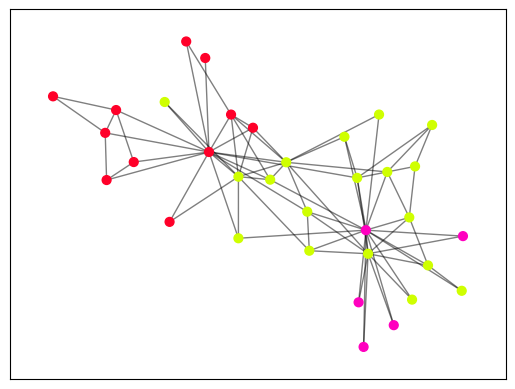

In [230]:
clust=part(G,3)
cmap = cm.get_cmap('gist_rainbow', int(np.max(clust)+1))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=clust)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

## Averaging partitions

We would like to calculate an "average". 

### Version 1

Here is one version which compares entire partitions. $n$ is the number of partitions to compare. Expected calculation time: about $n \cdot 0.5 \text{s}$. 
At the end, the partition which happend most, its likelihood and modularity are printed.
Moreover, the average number of clusters and modularity are printed.

In [114]:
n=10
G=nx.karate_club_graph()
res=np.array([[part(G,3),1]])
for i in range(n-1):
    p=part(G,3)
    b=0
    for k in range(len(res[:,0])):
        if (res[k,0]==p).all():
            res[k,1]=res[k,1]+1
            b=1
    if b==0:
        res=np.vstack([res,[p,1]])
print('Probability of most likely partition:',np.max(res[:,1])/n)
print('Its modularity:',modularity(res[np.argmax(res[:,1]),0],G))
print('How it looks like:',res[np.argmax(res[:,1]),0])
anum=0
amod=0
for i in range(len(res[:,0])):
    for j in range(int(max(res[i,0]))):
        if any(res[i,0]==j+1):
            anum=anum+res[i,1]
    amod=amod+res[i,1]*modularity(res[i,0],G)
print('Average number of clusters:',anum/n)
print('Average modularity:',amod/n)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1896/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1896/4000154065.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[part(G),1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Probability of most likely partition: 0.3
Its modularity: 0.0
How it looks like: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average number of clusters: 1.3
Average number of clusters: 0.0661817882971729


### Version 2

Now we compare families of vertices among different partitions. In other words, we check if there are communities that are formed in several partitions (and these partitions differ somewhere else). Expected duration about $n\cdot 0.4 \text{s}$.

In [251]:
n=100
G=nx.karate_club_graph()
p=part(G,3)
if len(np.nonzero(p==1)[0])!=0:
    res=np.array([[np.nonzero(p==1)[0],1]])
for k in range(1,int(np.max(p))):
    if len(np.nonzero(p==k+1)[0])!=0:
        res=np.vstack([res,[np.nonzero(p==k+1)[0],1]])
for i in range(n-1):
    p=part(G,3)
    for l in range(int(np.max(p))):
        v=np.nonzero(p==l+1)[0]
        if len(v)!=0:
            for k in range(len(res[:,0])):
                b=0
                if len(res[k,0])==len(v) and (res[k,0]==v).all():
                    res[k,1]=res[k,1]+1
                    b=1
            if b==0:
                res=np.vstack([res,[v,1]])
print(np.max(res[:,1]))
print(res[np.argmax(res[:,1]),:])

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/2872942502.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[np.nonzero(p==1)[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


27
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])
 27]


In both versions we observe that the "all is one" partition dominates (for spread 3).

## Modifying parameters

### The initial distribution

The first thing to change is the initial distribution. We will define a parameter $r$ and start with a uniform distribution on $-r/2,r/2$ 

In [47]:
def basicalg(N,r,G):
    """
    Running the experiment N times for r and G, giving average modularity, top modularity and average number of clusters
    Output: r, frequency of most likely outcome, its modularity, average nr of clusters, average modularity, which one is most likely partition
    """
    horst=part(G,r)
    restarts=horst[1]
    res=np.array([[horst[0],1]])
    mod=[]
    num=[]
    for i in range(N-1):
        p=part(G,r)
        restarts=restarts+p[1]
        for k in range(len(res[:,0])):
            if (res[k,0]==p[0]).all():
                res[k,1]=res[k,1]+1
                break
        else:
            res=np.vstack([res,[p[0],1]])
        mod.append(modularity(p[0],G))
        anum=0
        for j in range(int(max(p[0]))):
            if any(p[0]==j+1):
                anum=anum+1
        num.append(anum)
    out=[r,np.max(res[:,1])/N,modularity(res[np.argmax(res[:,1]),0],G),mean(num),stdev(num),mean(mod),stdev(mod),len(res[:,1]),res[np.argmax(res[:,1]),0],restarts]
    return out

In [7]:
G=nx.karate_club_graph()
part(G,3)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()


[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0]

Erste Erkenntnisse für phi: $r=5$ ist zu groß: wir bekommen im Durchschnitt 7 cluster und keine Dopplung (bei n=100)
Selbst bei $r=4$ und $n=100$ noch keine Dopplung, aber nur $4.4$ cluster
Bei $3.5$ gibt es Dopplung, dann ist aber das alles in eins das Wahrscheinlichste

In [52]:
n=1000
G=nx.karate_club_graph()
data=basicalg(n,2.5,G)
for r in [2.8,3,3.2,3.4,3.6,3.8,4,4.5,5,5.5,6,7,8]:
    data=np.vstack([data,basicalg(n,r,G)])
    print(r,'done')
data

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/867601489.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[horst[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


2.8 done
3 done
3.2 done
3.4 done
3.6 done
3.8 done
4 done
4.5 done
5 done
5.5 done
6 done
7 done
8 done


array([[2.5, 0.634, 0.0, 1.5715715715715717, 0.9090023118995407,
        0.03429415608902788, 0.06713117211116913, 300,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [2.8, 0.371, 0.0, 2.1471471471471473, 1.1445476608973084,
        0.07013152205459898, 0.08287061775110009, 560,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [3, 0.24, 0.0, 2.4844844844844847, 1.2183917540932367,
        0.09209299700752692, 0.08932932289827272, 698,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [3.2, 0.145, 0.0, 2.863863863863864, 1.3095477525152417,
        0.1021948148016524, 0.085958351

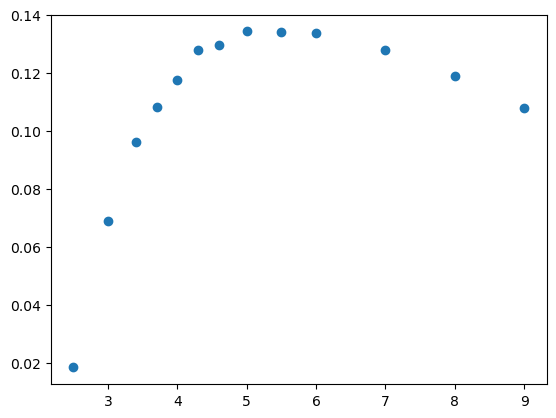

In [45]:
plt.scatter(data[:,0],data[:,5])


To export the data as a csv file, use the following:

In [75]:
with open('/Users/arne/Documents/Uni/LSGNT/TDA/Data/nonconst_n10000_13min.csv','w') as f:
    writer = csv.writer(f)
    for k in [0,1,2,3,4,5]:
        writer.writerow(data[:,k])

### Different sheaves

Next, we want to use a different sheaf than the constant one $\mathbb R$ and its opinion dynamics: first $\mathbb R^n$, then a non-constant one.

So we want to work with vector spaces as stalks and for that we have to rewrite some of our functions:

In [54]:
def vecabl(t,arr):
    """
    The derivative function for solving the dynamics for the constant sheaf R^n, have to give n separately!
    """
    inc=nx.incidence_matrix(G,oriented=True).toarray()
    v=[]
    for k in nx.edges(G):
        v=np.append(v,[phi(np.linalg.norm(np.array([arr[n*k[0]+i] for i in range(n)])-np.array([arr[n*k[1]+i] for i in range(n)])))])
    return -np.dot(np.kron(np.matmul(np.matmul(inc,np.diag(v)),np.transpose(inc)),np.identity(n)),arr)

In [55]:
def vectest(lsg):
    """
    tests if a solution needs to be further calculated (1) or already converged sufficiently (0), takes n from vecsol
    """
    t=0
    for k in nx.edges(G):
        if np.linalg.norm(np.array([lsg[n*k[0]+i] for i in range(n)])-np.array([lsg[n*k[1]+i] for i in range(n)]))>0.0033 and np.linalg.norm(np.array([lsg[n*k[0]+i] for i in range(n)])-np.array([lsg[n*k[1]+i] for i in range(n)]))<1:
            t=1
    return t

In [56]:
def vecsol(G,r,n):
    """
    solves the dynamics for a given graph and a random starting distribution on -r/2,r/2
    """
    b=0
    restarts=0
    while b==0:
        y=[] #start value
        for i in range(G.number_of_nodes()):
            x = np.random.normal(size=(1, n)) 
            x /= np.linalg.norm(x, axis=1)[:, np.newaxis]
            radius=r/2*np.random.random()
            y=np.append(y,radius**(1/n)*x)
        # print(y)
        sol=scipy.integrate.solve_ivp(vecabl,[0,1],y,t_eval=[1])
        s=1
        while vectest(sol.y[:,0])==1 and s<1000:
            # print(s,sol)
            sol=scipy.integrate.solve_ivp(vecabl,[0,1],sol.y[:,0],t_eval=[1])
            s=s+1
        if s==1000:
            restarts=restarts+1
        if s<1000:
            b=1
    return [sol,restarts]

In [69]:
def vecpart(G,r,n):
    """
    Calculates a partition of a given graph
    """
    horst=vecsol(G,r,n)
    sollim=horst[0]
    cluster=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        if cluster[i]==0:
            cluster[i]=np.max(cluster)+1
            for k in range(i,G.number_of_nodes()):
                if np.linalg.norm(np.array([sollim.y[n*i+j][0] for j in range(n)])-np.array([sollim.y[n*k+j][0] for j in range(n)]))<0.01:
                    cluster[k]=cluster[i]
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return [cluster,horst[1]]

In [58]:
def vecalg(N,G,r,n):
    """
    Running the experiment N times for G,r,n, giving average modularity, top modularity and average number of clusters
    Output: r, frequency of most likely outcome, its modularity, average nr of clusters, average modularity, which one is most likely partition
    """
    horst=vecpart(G,r,n)
    restarts=horst[1]
    res=np.array([[horst[0],1]])
    mod=[]
    num=[]
    for i in range(N-1):
        p=vecpart(G,r,n)
        restarts=restarts+p[1]
        for k in range(len(res[:,0])):
            if (res[k,0]==p[0]).all():
                res[k,1]=res[k,1]+1
                break
        else:
            res=np.vstack([res,[p[0],1]])
        mod.append(modularity(p[0],G))
        anum=0
        for j in range(int(max(p[0]))):
            if any(p[0]==j+1):
                anum=anum+1
        num.append(anum)
    out=[r,np.max(res[:,1])/N,modularity(res[np.argmax(res[:,1]),0],G),mean(num),stdev(num),mean(mod),stdev(mod),len(res[:,1]),res[np.argmax(res[:,1]),0],restarts]
    return out

In [76]:
N=100 
n=10
G=nx.karate_club_graph()
data=vecalg(N,G,2,n)
for r in [2.3,2.6,2.8,3,3.2,3.4,3.7,4,4.3,4.6,5,5.5,6]:
    data=np.vstack([data,vecalg(N,G,r,n)])
    print(r,'done')
data

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/3071812321.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/995777138.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[horst[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


2.3 done
2.6 done
2.8 done
3 done
3.2 done
3.4 done
3.7 done
4 done
4.3 done
4.6 done
5 done
5.5 done
6 done
7 done


array([[2, 0.56, 0.0, 4.232323232323233, 6.3371729402034305,
        0.01105316810445016, 0.027716538077788587, 43,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [2.3, 0.44, 0.0, 3.8585858585858586, 4.37061173743331,
        0.010923667974950016, 0.020026740699667336, 55,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [2.6, 0.25, 0.0, 7.626262626262626, 7.609856469168394,
        0.023150638535253905, 0.03528645696204276, 75,
        array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
               1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
        0],
       [2.8, 0.18, 0.0, 9.212121212121213, 7.585260582709514,
        0.035908061549087184, 0.038860183886710

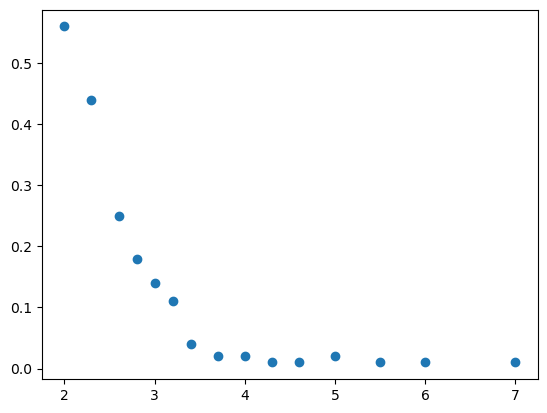

In [81]:
plt.scatter(data[:,0],data[:,1])

The non-constant sheaf is equivalent to deleting each edge with the same probability. So instead of using the differential equation, we will code that:

In [78]:
n=1
vecalg(200,nx.karate_club_graph(),5,n)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_755/3071812321.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_755/995777138.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[horst[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[5,
 0.005,
 0.28690006574621957,
 7.271356783919598,
 2.6221152823399114,
 0.13756487896418318,
 0.0638657708043714,
 200,
 array([1., 2., 1., 1., 1., 3., 3., 4., 1., 1., 1., 1., 1., 1., 8., 8., 3.,
        2., 8., 8., 8., 1., 8., 8., 8., 8., 8., 8., 1., 8., 8., 8., 8., 8.]),
 7]

In [81]:
basicalg(200,5,nx.karate_club_graph())

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_755/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_755/2489817112.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[horst[0],1]])


[5,
 0.005,
 0.07010190664036822,
 7.482412060301508,
 2.6927591292833197,
 0.13778995239180783,
 0.06145376827794253,
 200,
 array([ 1.,  1.,  1.,  1.,  3.,  4.,  5.,  1.,  6.,  7.,  1.,  1.,  1.,
         1.,  8.,  1.,  5.,  1.,  1.,  1.,  1.,  1.,  9.,  1., 10., 11.,
        14., 13.,  1., 14.,  1.,  1.,  1., 14.]),
 0]

In [4]:
def nonconstpart(p,G):
    """
    each edge is kept with probability p and otherwise ignored, the connected components give a partition of the graph
    """
    #v=[] that was just to test
    part=[i+1 for i in range(nx.number_of_nodes(G))]
    for e in nx.edges(G):
        #k=0
        if np.random.random()<p:
            b=part[e[1]]
            for a in range(nx.number_of_nodes(G)):
                if part[a]==b:
                    part[a]=part[e[0]]
            #k=1
        #v.append(k)
    #print(v)
    cluster=np.array(part)
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return cluster

In [19]:
def nonconstpart2(p,G):
    """
    each edge is kept with probability p that depends on the vertices and otherwise ignored, the connected components give a partition of the graph
    """
    #v=[] that was just to test
    part=[i+1 for i in range(nx.number_of_nodes(G))]
    for e in nx.edges(G):
        #k=0
        if np.random.random()<p*nx.get_edge_attributes(G,"pkeep")[e]:
            b=part[e[1]]
            for a in range(nx.number_of_nodes(G)):
                if part[a]==b:
                    part[a]=part[e[0]]
            #k=1
        #v.append(k)
    #print(v)
    cluster=np.array(part)
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return cluster

In [58]:
def nonconstpart3(p,G):
    """
    each edge is kept if relative number of common neighbors is large enough and otherwise ignored, the connected components give a partition of the graph
    """
    #v=[] that was just to test
    part=[i+1 for i in range(nx.number_of_nodes(G))]
    for e in nx.edges(G):
        #k=0
        if p<nx.get_edge_attributes(G,"pkeep")[e]:
            b=part[e[1]]
            for a in range(nx.number_of_nodes(G)):
                if part[a]==b:
                    part[a]=part[e[0]]
            #k=1
        #v.append(k)
    #print(v)
    cluster=np.array(part)
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]]
    return cluster

In [49]:
def nonconstalg(p,G,n):
    """
    Running the experiment n times for p and G, giving average modularity, top modularity and average number of clusters
    Output: r, frequency of most likely outcome, its modularity, average nr of clusters, average modularity, which one is most likely partition
    """
    res=np.array([[nonconstpart3(p,G),1]])
    mod=[]
    num=[]
    for i in range(n-1):
        pa=nonconstpart3(p,G)
        for k in range(len(res[:,0])):
            if (res[k,0]==pa).all():
                res[k,1]=res[k,1]+1
                break
        else:
            res=np.vstack([res,[pa,1]])
        mod.append(modularity(pa,G))
        anum=0
        for j in range(int(max(pa))):
            if any(pa==j+1):
                anum=anum+1
        num.append(anum)
    out=[p,np.max(res[:,1])/n,modularity(res[np.argmax(res[:,1]),0],G),mean(num),stdev(num),mean(mod),stdev(mod),len(res[:,1]),res[np.argmax(res[:,1]),0]]
    return out

In [ ]:
n=3
G=nx.karate_club_graph()
for e in nx.edges(G):
    nx.set_edge_attributes(G, {e: {"pkeep": (2*len(sorted(nx.common_neighbors(G,e[0],e[1]))))/(G.degree(e[0])+G.degree(e[1]))}})
data=nonconstalg(0.2,G,n)
for t in range(19):
    p=0.21+0.01*t
    data=np.vstack([data,nonconstalg(p,G,n)])
    print(p,'done')
data

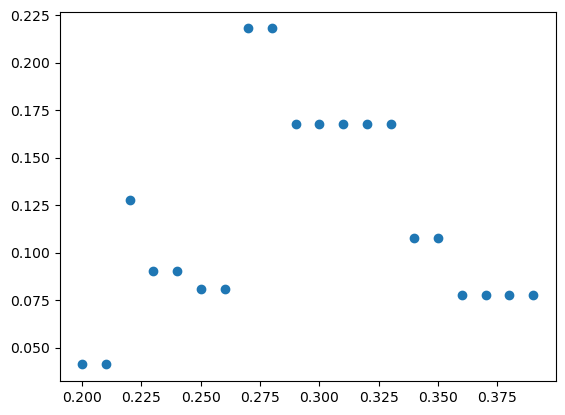

In [60]:
plt.scatter(data[:,0],data[:,5])

In [51]:
G=nx.karate_club_graph()
nonconstalg(0.25,G,2000)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_755/1263368933.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[nonconstpart(p,G),1]])


[0.25,
 0.0025,
 0.0,
 10.772386193096548,
 4.376284923157783,
 0.1249475411604553,
 0.0754427242839615,
 1986,
 array([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27])]

In [53]:
with open('/Users/arne/Documents/Uni/LSGNT/TDA/Data/basic_phi1_n1000_130min.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(['p','pmax','q0','num','numerr','qav','qaverr','anz','mostfrequent','restarts'])
    for k in range(len(data[:,0])):
        writer.writerow(data[k,:])

In [68]:
n=2
G=nx.karate_club_graph()
vecalg(10,G,3,n)

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/3071812321.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_1278/995777138.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[horst[0],1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


[3,
 0.2,
 0.0,
 2.7777777777777777,
 1.3944333775567925,
 0.049355321791219244,
 0.05385990176208464,
 9,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 20]

In [59]:
def detealt(p,q,G):
    """
    each edge is kept if an inequality between number of common neighbors and sum of neighbors is satisfied and otherwise ignored, the connected components give a partition of the graph
    """
    #v=[] that was just to test
    part=[i+1 for i in range(nx.number_of_nodes(G))]
    for e in nx.edges(G):
        #k=0
        if p*(G.degree(e[0])+G.degree(e[1]))<q+len(sorted(nx.common_neighbors(G,e[0],e[1]))):
            b=part[e[1]]
            for a in range(nx.number_of_nodes(G)):
                if part[a]==b:
                    part[a]=part[e[0]]
            #k=1
        #v.append(k)
    #print(v)
    cluster=np.array(part)
    degrees=np.array(list(G.degree))[:,1]
    for l in G.nodes():
        if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
            cluster[l]=cluster[[k for k in G.neighbors(l)][0]] # removes most 1-point clusters
    anum=0
    for j in range(int(max(cluster))):
        if any(cluster==j+1):
            anum=anum+1
    out=[p,q,modularity(cluster,G),anum,cluster]
    return out

In [66]:
def deterministic(p,q,G):
    """
    each edge is kept if an inequality between number of common neighbors and sum of neighbors is satisfied and otherwise ignored, the connected components give a partition of the graph
    """
    #v=[] that was just to test
    part=[i+1 for i in range(nx.number_of_nodes(G))]
    for e in nx.edges(G):
        #k=0
        if p*(G.degree(e[0])+G.degree(e[1]))<q+len(sorted(nx.common_neighbors(G,e[0],e[1]))):
            b=part[e[1]]
            for a in range(nx.number_of_nodes(G)):
                if part[a]==b:
                    part[a]=part[e[0]]
            #k=1
        #v.append(k)
    #print(v)
    cluster=np.array(part)
    degrees=np.array(list(G.degree))[:,1]
    for l in G.nodes():
        for m in range(nx.number_of_nodes(G)):
            if cluster[l]==cluster[m] and m !=l:
                break
        else: # here we have identified a single vertex cluster
            ncl=np.array([[0,0,1],[0,0,1]]) # used to find best neighbor cluster to add l to
            for k in G.neighbors(l):
                for j in range(len(ncl[:,1])):
                    if cluster[k]==ncl[j,0]:
                        ncl[j,1]=ncl[j,1]+1
                        break
                else:
                    ncl=np.vstack((ncl, np.array([cluster[k],1,np.dot(cluster==cluster[k],degrees)])))
            cluster[l]=ncl[np.argmax(ncl[:,1]/ncl[:,2]),0]
        #if np.min([cluster[k] for k in G.neighbors(l)])==np.max([cluster[k] for k in G.neighbors(l)]):
        #    cluster[l]=cluster[[k for k in G.neighbors(l)][0]] # removes most 1-point clusters, but there is a better way!
    anum=0
    for j in range(int(max(cluster))):
        if any(cluster==j+1):
            anum=anum+1
    out=[p,q,modularity(cluster,G),anum,cluster]
    return out

In [68]:
G=nx.karate_club_graph()
data=deterministic(0,0,G)
for p in range(100):
    for q in range(100):
        data=np.vstack([data,deterministic(0.01*p,0.01*q,G)])
data[np.argmax(data[:,2])]

/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


array([0.17, 0.54, 0.3998191978961209, 5,
       array([ 1,  1,  1,  1,  6,  6,  6,  1,  9,  9,  6,  1,  1,  1,  9,  9,  6,
               1,  9,  1,  9,  1,  9, 27, 29, 29, 27, 27, 29, 27,  9, 29,  9,  9])],
      dtype=object)

In [67]:
print(detealt(0.2,0.9,G))
print(deterministic(0.2,0.9,G))

[0.2, 0.9, 0.3833004602235371, 7, array([ 1,  1,  1,  1,  6,  6,  6,  1,  9, 10,  6,  1,  1,  1,  9,  9,  6,
        1,  9, 20,  9,  1,  9, 27, 29, 29, 27, 27, 29, 27,  9, 29,  9,  9])]
[0.2, 0.9, 0.3998191978961209, 5, array([ 1,  1,  1,  1,  6,  6,  6,  1,  9,  9,  6,  1,  1,  1,  9,  9,  6,
        1,  9,  1,  9,  1,  9, 27, 29, 29, 27, 27, 29, 27,  9, 29,  9,  9])]


In [65]:
cluster=[1,2,3,2,3]
cluster[2]==cluster[4] and 2 !=2

False